In [3]:
# Source - https://stackoverflow.com/a
# Posted by Kenneth Dsouza, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-08, License - CC BY-SA 4.0

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [4]:
!pip install pandas sqlalchemy psycopg2-binary tqdm -q

import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from tqdm import tqdm
import os

print("Libraries ready!")

Libraries ready!


In [17]:

DB_USER = "postgres"
DB_PASS = "postgres123"                  
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "intrusion_db"

CSV_PATH = "KDDTrain+.txt"               


print("Configuration set!")
print("CSV path:", CSV_PATH)
print("Current notebook folder:", os.getcwd())

Configuration set!
CSV path: KDDTrain+.txt
Current notebook folder: C:\Users\prera\Projects


In [6]:
if os.path.exists(CSV_PATH):
    print("File FOUND!")
    print(f"Size: {os.path.getsize(CSV_PATH) / (1024 * 1024):.2f} MB")
    
    # Show first 3 lines raw
    with open(CSV_PATH, 'r', encoding='latin1') as f:
        lines = f.readlines()[:3]
        for line in lines:
            print(line.strip())
else:
    print("File NOT found — check path or file name")
    print("Files in current folder:", os.listdir('.'))

File FOUND!
Size: 18.22 MB
0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.00,0.00,0.00,0.00,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.00,1.00,0.00,0.00,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19


In [7]:
print("Loading NSL-KDD training set...")

column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

needed_cols = [
    'duration', 'src_bytes', 'dst_bytes', 'land', 'logged_in',
    'count', 'srv_count', 'serror_rate', 'rerror_rate', 'same_srv_rate',
    'dst_host_count', 'dst_host_srv_count', 'difficulty_level',
    'protocol_type', 'service', 'flag', 'label'
]

df = pd.read_csv(
    CSV_PATH,
    header=None,
    names=column_names,
    usecols=needed_cols,
    dtype={'protocol_type': str, 'service': str, 'flag': str, 'label': str}
)

print(f"Loaded {len(df):,} rows with {len(df.columns)} columns")
print("Columns:", df.columns.tolist())
print("\nFirst 3 rows:")
display(df.head(3))

print("\nprotocol_type top values:")
print(df['protocol_type'].value_counts().head(5))

Loading NSL-KDD training set...
Loaded 125,973 rows with 17 columns
Columns: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'logged_in', 'count', 'srv_count', 'serror_rate', 'rerror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'label', 'difficulty_level']

First 3 rows:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,logged_in,count,srv_count,serror_rate,rerror_rate,same_srv_rate,dst_host_count,dst_host_srv_count,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,2,2,0.0,0.0,1.00,150,25,normal,20
1,0,udp,other,SF,146,0,0,0,13,1,0.0,0.0,0.08,255,1,normal,15
2,0,tcp,private,S0,0,0,0,0,123,6,1.0,0.0,0.05,255,26,neptune,19



protocol_type top values:
protocol_type
tcp     102689
udp      14993
icmp      8291
Name: count, dtype: int64


In [8]:
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

print("Connecting to database...")
try:
    with engine.connect() as conn:
        print("Connection OK!")
except Exception as e:
    print("Connection failed:", e)

# Load lookups
protocol_map = pd.read_sql("SELECT protocol_id, protocol_name FROM protocol_types", engine)
protocol_dict = dict(zip(protocol_map['protocol_name'], protocol_map['protocol_id']))

service_map = pd.read_sql("SELECT service_id, service_name FROM services", engine)
service_dict = dict(zip(service_map['service_name'], service_map['service_id']))

flag_map = pd.read_sql("SELECT flag_id, flag_value FROM flags", engine)
flag_dict = dict(zip(flag_map['flag_value'], flag_map['flag_id']))

attack_map = pd.read_sql("SELECT attack_id, attack_name FROM attack_types", engine)
attack_dict = dict(zip(attack_map['attack_name'], attack_map['attack_id']))

if 'normal' not in attack_dict:
    attack_dict['normal'] = 1  # fallback

print(f"Mappings loaded: {len(protocol_dict)} protocols, {len(service_dict)} services, {len(flag_dict)} flags, {len(attack_dict)} attacks")

Connecting to database...
Connection OK!
Mappings loaded: 3 protocols, 5 services, 5 flags, 5 attacks


In [9]:
print("Mapping string columns to IDs...")

df['protocol_type'] = df['protocol_type'].astype(str).str.strip()
df['service']       = df['service'].astype(str).str.strip()
df['flag']          = df['flag'].astype(str).str.strip()
df['label']         = df['label'].astype(str).str.strip()

df['protocol_id'] = df['protocol_type'].map(protocol_dict)
df['service_id']   = df['service'].map(service_dict)
df['flag_id']      = df['flag'].map(flag_dict)
df['attack_id']    = df['label'].map(attack_dict)

print("Missing mappings:")
print(f"  protocol_id: {df['protocol_id'].isna().sum():,}")
print(f"  service_id:   {df['service_id'].isna().sum():,}")
print(f"  flag_id:      {df['flag_id'].isna().sum():,}")
print(f"  attack_id:    {df['attack_id'].isna().sum():,}")

df_clean = df.dropna(subset=['protocol_id', 'service_id', 'flag_id', 'attack_id'])
df_clean = df_clean.drop(columns=['protocol_type', 'service', 'flag', 'label'], errors='ignore')

print(f"\nAfter cleaning: {len(df_clean):,} rows remaining")
print("Final columns:", df_clean.columns.tolist())
df_clean.head(3)

Mapping string columns to IDs...
Missing mappings:
  protocol_id: 0
  service_id:   40,566
  flag_id:      961
  attack_id:    7,538

After cleaning: 80,076 rows remaining
Final columns: ['duration', 'src_bytes', 'dst_bytes', 'land', 'logged_in', 'count', 'srv_count', 'serror_rate', 'rerror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'difficulty_level', 'protocol_id', 'service_id', 'flag_id', 'attack_id']


,duration,src_bytes,dst_bytes,land,logged_in,count,srv_count,serror_rate,rerror_rate,same_srv_rate,dst_host_count,dst_host_srv_count,difficulty_level,protocol_id,service_id,flag_id,attack_id
0,0,491,0,0,0,2,2,0.0,0.0,1.00,150,25,20,1,2.0,1.0,1.0
2,0,0,0,0,0,123,6,1.0,0.0,0.05,255,26,19,1,3.0,2.0,2.0
3,0,232,8153,0,1,5,5,0.2,0.0,1.00,30,255,21,1,1.0,1.0,1.0


In [10]:
print("Preparing & inserting cleaned data...")

# Fix boolean columns (0/1 → True/False)
df_clean['land'] = df_clean['land'].astype(int).astype(bool)
df_clean['logged_in'] = df_clean['logged_in'].astype(int).astype(bool)

# Confirm types (optional debug)
print("Data types before insert:")
print(df_clean.dtypes)

chunksize = 10000
total = 0

for i in tqdm(range(0, len(df_clean), chunksize)):
    chunk = df_clean[i:i+chunksize]
    chunk.to_sql('connections', engine, if_exists='append', index=False)
    total += len(chunk)
    print(f"Inserted chunk {i//chunksize + 1}: {len(chunk):,} rows")

print(f"\nInsertion complete! Total rows inserted: {total:,}")

Preparing & inserting cleaned data...
Data types before insert:
duration                int64
src_bytes               int64
dst_bytes               int64
land                     bool
logged_in                bool
count                   int64
srv_count               int64
serror_rate           float64
rerror_rate           float64
same_srv_rate         float64
dst_host_count          int64
dst_host_srv_count      int64
difficulty_level        int64
protocol_id             int64
service_id            float64
flag_id               float64
attack_id             float64
dtype: object


 11%|█         | 1/9 [00:03<00:24,  3.12s/it]

Inserted chunk 1: 10,000 rows


 22%|██▏       | 2/9 [00:06<00:21,  3.12s/it]

Inserted chunk 2: 10,000 rows


 33%|███▎      | 3/9 [00:09<00:17,  2.98s/it]

Inserted chunk 3: 10,000 rows


 44%|████▍     | 4/9 [00:10<00:12,  2.48s/it]

Inserted chunk 4: 10,000 rows


 56%|█████▌    | 5/9 [00:12<00:08,  2.22s/it]

Inserted chunk 5: 10,000 rows


 67%|██████▋   | 6/9 [00:15<00:07,  2.52s/it]

Inserted chunk 6: 10,000 rows


 78%|███████▊  | 7/9 [00:18<00:05,  2.67s/it]

Inserted chunk 7: 10,000 rows


100%|██████████| 9/9 [00:21<00:00,  2.40s/it]

Inserted chunk 8: 10,000 rows
Inserted chunk 9: 76 rows

Insertion complete! Total rows inserted: 80,076


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load data from DB
query = "SELECT * FROM connections"
data = pd.read_sql(query, engine)

# Features (exclude PK and target)
X = data.drop(columns=['connection_id', 'attack_id'])
y = data['attack_id']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict & evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9999791866128294
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     35807
           2       1.00      1.00      1.00     10697
           4       1.00      1.00      1.00      1324
           5       1.00      1.00      1.00       218

    accuracy                           1.00     48046
   macro avg       1.00      1.00      1.00     48046
weighted avg       1.00      1.00      1.00     48046



Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     35807
           2       1.00      1.00      1.00     10697
           4       1.00      1.00      1.00      1324
           5       1.00      1.00      1.00       218

    accuracy                           1.00     48046
   macro avg       1.00      1.00      1.00     48046
weighted avg       1.00      1.00      1.00     48046



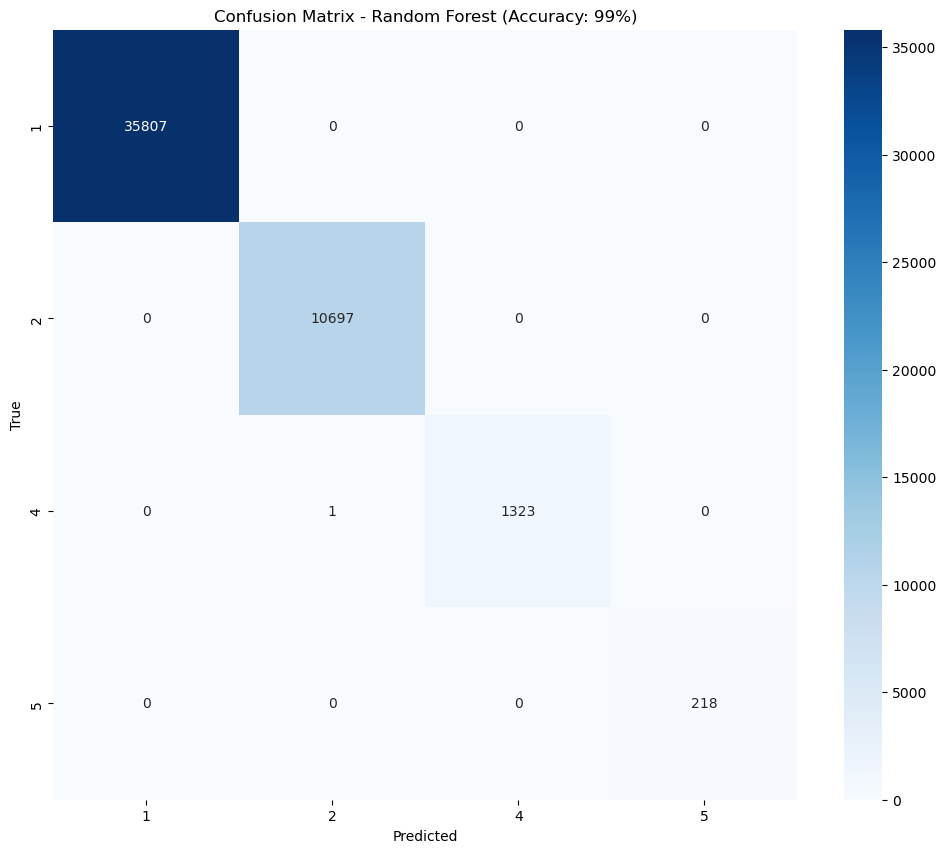

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns



# Cell: Detailed metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(x) for x in sorted(y_test.unique())]))

# Cell: Confusion Matrix (visual)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest (Accuracy: 99%)')
plt.show()

In [13]:
# Save classification report as text
with open('classification_report.txt', 'w') as f:
    f.write(classification_report(y_test, y_pred, target_names=[str(x) for x in sorted(y_test.unique())]))

print("Classification report saved as classification_report.txt")

Classification report saved as classification_report.txt


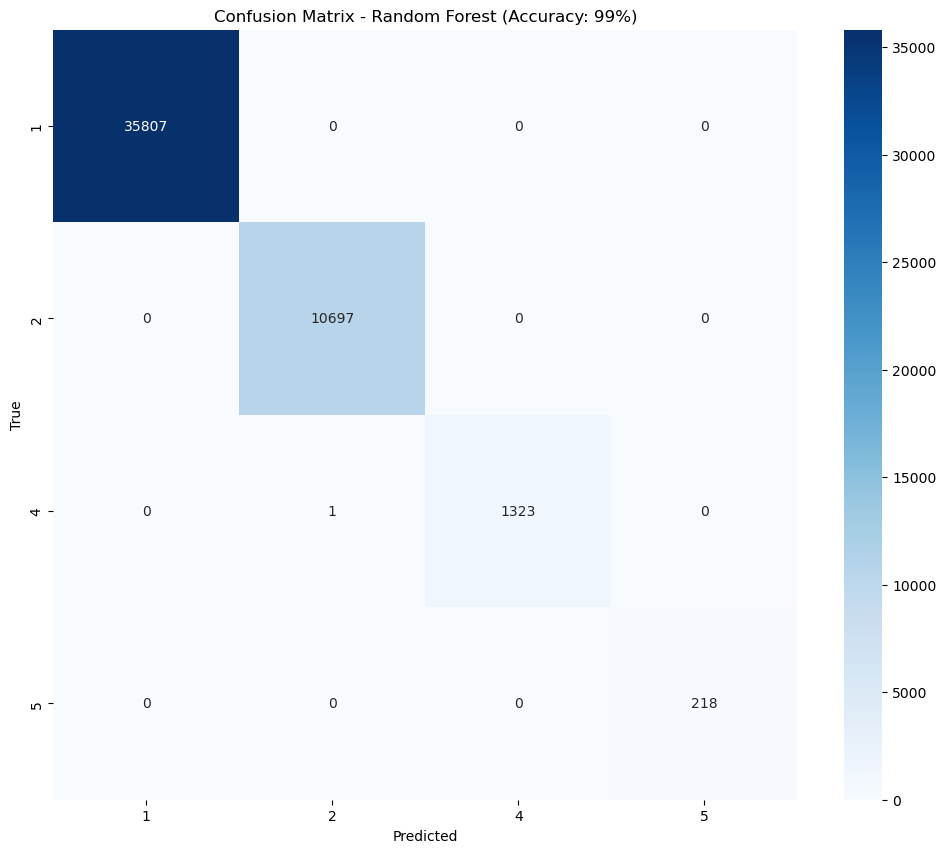

Confusion matrix saved as confusion_matrix.png


In [15]:
# Save confusion matrix as image
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest (Accuracy: 99%)')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved as confusion_matrix.png")

In [16]:
import joblib

joblib.dump(model, 'intrusion_model.pkl')
print("Model saved as intrusion_model.pkl")

Model saved as intrusion_model.pkl
